In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.linalg import solve_banded
import matplotlib.animation as animation


In [7]:
#This part of the code 
# Constants and Parameters
L = 1e-8  # Length of the potential well in meters
N = 1000  # Number of spatial divisions within the well
a = L / N  # Spatial grid size delta x
m = 9.10938356e-31  # Mass of an electron, kg
tau = 1e-18  # Time step for simulation (in paper, this is h)
hbar = 1.0545718e-34  # Reduced Planck's constant, J*s

# Wavefunction constants
x0 = L / 2  # Initial position center of the well
sigma = 1e-10  # Width of the wave packet in meters
k = 5e10  # Initial wave number relates to the particle's momentum

# Define the spatial grid and initialize the wavefunction
x = np.linspace(0, L, N)  # N spatial points within the well

# Function for the initial wavefunction
def initial_wave_function(x, x0=x0, sigma=sigma, k=k):
    A = (1 / (sigma * sigma * 2 * np.pi)) ** 0.25
    psi = A*np.exp(-(x - x0) ** 2 / (4 * sigma**2)) * np.exp(1j * k * x)
        #A = 1/(np.sqrt(np.sum(np.abs(psi)**2))) creating the normalization constant after psi is made

    return psi

# Initialize the wavefunction and apply boundary conditions
psi = initial_wave_function(x)
psi[0] = 0
psi[-1] = 0

In [8]:

# Coefficients for the banded matrix setup
a1 = 1 + ((hbar * tau) / (2 * m * a * a)) * 1j  # Diagonal elements for A
a2 = -((hbar * tau) / (4 * m * a * a)) * 1j  # Off-diagonal elements for A
b1 = 1 - ((hbar * tau) / (2 * m * a * a)) * 1j  # Diagonal elements for B
b2 = ((hbar * tau) / (4 * m * a * a)) * 1j  # Off-diagonal elements for B

#constructing the matricies 
A = np.zeros((N,N), dtype=complex)
B = np.zeros((N,N), dtype=complex)

# Construct banded matrices
A_banded = np.zeros((3, N), dtype=complex)
B_banded = np.zeros((3, N), dtype=complex)

A_banded[0, 1:] = a2  # Upper diagonal
A_banded[1, :] = a1   # Main diagonal
A_banded[2, :-1] = a2  # Lower diagonal

B_banded[0, 1:] = b2  # Upper diagonal
B_banded[1, :] = b1   # Main diagonal
B_banded[2, :-1] = b2  # Lower diagonal

# Time evolution parameters
time_steps = 2000

# Crank-Nicolson time evolution using solve_banded
def crank_nicolson(A_banded, B_banded, psi, time_steps):
    psi_evolution = np.zeros((time_steps + 1, len(psi)), dtype=complex)
    psi_evolution[0][:] = psi
    psi_last = psi

    for t in range(1, time_steps + 1):
        # Apply boundary conditions
        psi_last[0] = 0
        psi_last[-1] = 0

        # Solve the linear system A * psi_next = B * psi_last
        rhs = B_banded[1] * psi_last + np.roll(B_banded[0], -1) * np.roll(psi_last, -1) + np.roll(B_banded[2], 1) * np.roll(psi_last, 1)
        rhs[0] = 0  # Enforce boundary condition
        rhs[-1] = 0

        psi_next = solve_banded((1, 1), A_banded, rhs)
        psi_evolution[t][:] = psi_next
        psi_last = psi_next

    return psi_evolution

# Perform the time evolution
psi_evolution = crank_nicolson(A_banded, B_banded, psi, time_steps)


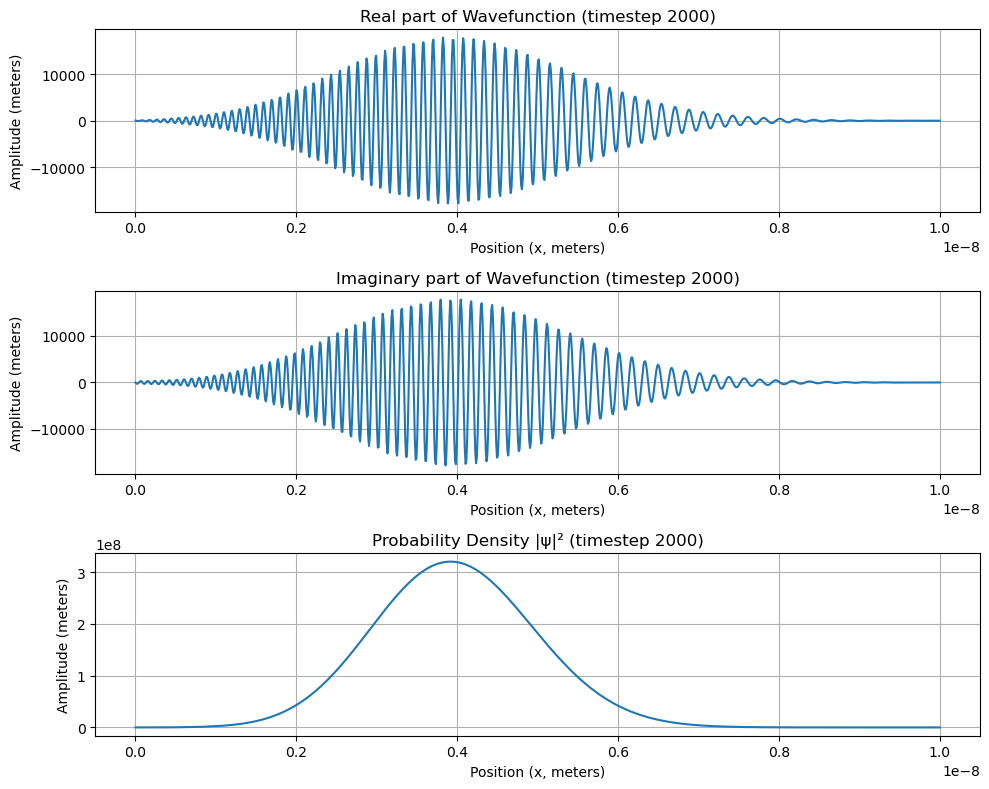

In [9]:

fig, ax = plt.subplots(3,1,figsize=(10,8))
ax[0].plot(x,np.real(psi_evolution[-1]))
ax[1].plot(x,np.imag(psi_evolution[-1]))
ax[2].plot(x,np.abs(psi_evolution[-1])**2)
ax[0].set_title("Real part of Wavefunction (timestep 2000)")
ax[1].set_title("Imaginary part of Wavefunction (timestep 2000)")
ax[2].set_title("Probability Density |ψ|² (timestep 2000)")
for a in ax:
    a.set_xlabel("Position (x, meters)")
    a.set_ylabel("Amplitude (meters)")
    a.grid()
plt.tight_layout()
plt.show()

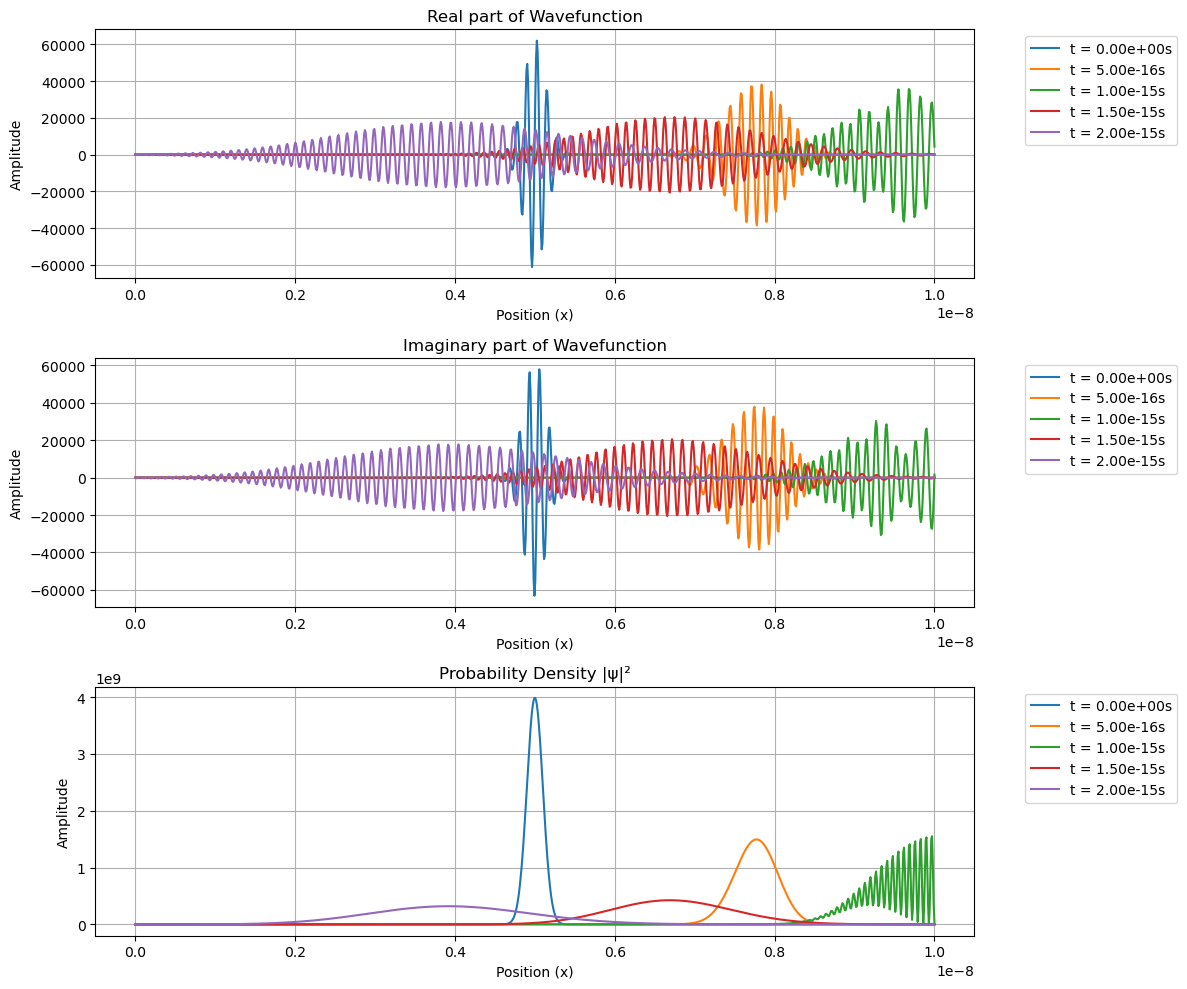

In [10]:
# Visualization
# Plot of the wavefucntion's amplitude 
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

for t in range(0, time_steps + 1, 500):  # Plot every 500th time step
    psi_graph = psi_evolution[t]
    ax[0].plot(x, np.real(psi_graph), label=f't = {t * tau:.2e}s') 
    ax[1].plot(x, np.imag(psi_graph), label=f't = {t * tau:.2e}s')
    ax[2].plot(x, (np.abs(psi_graph)**2), label=f't = {t * tau:.2e}s')

ax[0].set_title("Real part of Wavefunction")
ax[1].set_title("Imaginary part of Wavefunction")
ax[2].set_title("Probability Density |ψ|²")

for a in ax:
    a.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    a.set_xlabel("Position (x)")
    a.set_ylabel("Amplitude")
    a.grid()
plt.tight_layout()
plt.show()

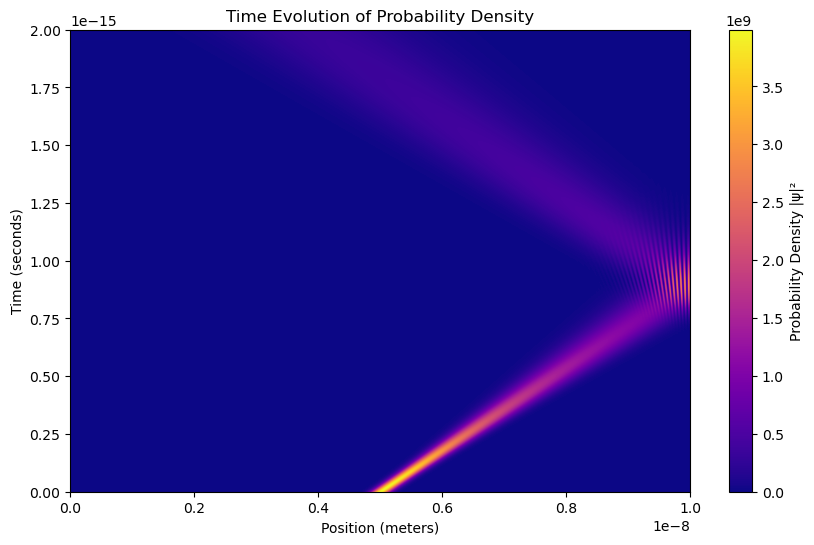

In [11]:
#creating Color Map
# Calculate probability densities
prob_density = np.abs(psi_evolution) ** 2

# Create the colormap
plt.figure(figsize=(10, 6))
plt.imshow(
    prob_density,
    extent=[ 0, L, 0, time_steps * tau,],
    aspect='auto',
    origin='lower',
    cmap='plasma',  # Use 'viridis' for a visually appealing colormap
)
plt.colorbar(label='Probability Density |ψ|²')
plt.xlabel('Position (meters)')
plt.ylabel('Time (seconds)')
plt.title('Time Evolution of Probability Density')
plt.show()

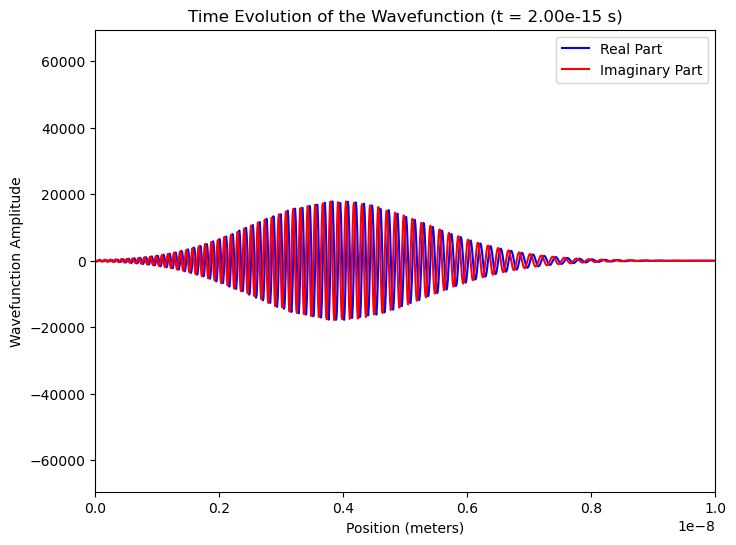

In [12]:
#Creates an animation for this 
# Extract real and imaginary parts of the wavefunction over time
psi_real = psi_evolution.real
psi_imag = psi_evolution.imag

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot initial states for real and imaginary parts
line_real, = ax.plot(x, psi_real[0], label="Real Part", color="blue")
line_imag, = ax.plot(x, psi_imag[0], label="Imaginary Part", color="red")

# Set up the plot limits and labels
ax.set_xlim(0, L)
ax.set_ylim(-np.max(np.abs(psi_real)) * 1.1, np.max(np.abs(psi_real)) * 1.1)
ax.set_xlabel("Position (meters)")
ax.set_ylabel("Wavefunction Amplitude")
ax.set_title("Time Evolution of the Wavefunction")
ax.legend()

# Update function for the animation
def update(frame):
    line_real.set_ydata(psi_real[frame])
    line_imag.set_ydata(psi_imag[frame])
    ax.set_title(f"Time Evolution of the Wavefunction (t = {frame * tau:.2e} s)")
    return line_real, line_imag


# Create the animation
ani = animation.FuncAnimation(
    fig, update, frames=len(psi_evolution), interval=.3, blit=True
)

# Display the animation
ani.save('TDSE_PiAB.gif', writer=animation.PillowWriter(fps=1000))
plt.show()
#Takes about 2 minutes to run 